[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sagar87/scPCA/blob/main/docs/notebooks/kang.ipynb)

<div class="admonition note"> 
    <p class="admonition-title">Note</p>
    <p>In order to run this notebook in Google Colab run the following cells. For best performance make sure that you run the notebook on a GPU instance, i.e. choose from the menu bar Runtime > Change Runtime > Hardware accelerator > GPU.</p> 
</div>

In [3]:
# Install scPCA + dependencies
!pip install --quiet scpca scikit-misc

In [2]:
# Download the Kang et. al. dataset
!wget https://www.huber.embl.de/users/harald/sc/kang.h5ad /content/kang.h5ad

# Analysing the lung cell populations in aging mice

In this notebook, we analyse the dataset from Angelidis et. al. in which the authors investigated lung cells of aging mice.

In [1]:
import scpca as scp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns

## Data preprocessing

We begin by importing the dataset with `scanpy`.

In [2]:
data_path = '/home/voehring/voehring/projects/2022-11-23_constantin/angelidis.h5ad'
adata = sc.read_h5ad(data_path)

In [3]:
adata

AnnData object with n_obs × n_vars = 14745 × 20908
    obs: 'barcode', 'mouse_id', 'age', 'cell_type', 'cell_id'
    uns: 'X_name', 'celltype_column', 'condition_column', 'main_assay'

Examining the obs field of the `adata` object reveals that the dataset includes two conditions (`age` column), corresponding to mice aged 3 and 24 months.

In [4]:
adata.obs

,barcode,mouse_id,age,cell_type,cell_id
muc3838:GCACTTTAGAAT,GCACTTTAGAAT,muc3838,24m,Ciliated_cells,muc3838:GCACTTTAGAAT
muc3838:TCCTGCTCCCTT,TCCTGCTCCCTT,muc3838,24m,Ciliated_cells,muc3838:TCCTGCTCCCTT
muc3838:TCCTGCTCCCTG,TCCTGCTCCCTG,muc3838,24m,Ciliated_cells,muc3838:TCCTGCTCCCTG
muc3838:TGCGAGTCTTCT,TGCGAGTCTTCT,muc3838,24m,Ciliated_cells,muc3838:TGCGAGTCTTCT
muc3838:TCCTGCTCCCTC,TCCTGCTCCCTC,muc3838,24m,Ciliated_cells,muc3838:TCCTGCTCCCTC
...,...,...,...,...,...
muc4657:ATCAAGACAGTG,ATCAAGACAGTG,muc4657,3m,Type_2_pneumocytes,muc4657:ATCAAGACAGTG
muc4657:GACTGCGCATGG,GACTGCGCATGG,muc4657,3m,Ciliated_cells,muc4657:GACTGCGCATGG
muc4657:ATGACCGAATGT,ATGACCGAATGT,muc4657,3m,Type_2_pneumocytes,muc4657:ATGACCGAATGT
muc4657:GTGTTTGGACCG,GTGTTTGGACCG,muc4657,3m,Cd4+_T_cells,muc4657:GTGTTTGGACCG


Before proceeding with the selection of highly variable genes, we filter out low-quality cells and red blood cells, as the latter are not representative of lung cell types.

In [5]:
adata = adata[~adata.obs['cell_type'].isin(['low_quality_cells', 'red_blood_cells'])]

In [6]:
adata.layers["counts"] = adata.X.copy()

/tmp/ipykernel_4487/1517723426.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [7]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat_v3",
    subset=True,
    layer="counts"
)

## Factor analysis

Next, we model the data using scPCA. One strategy is to treat the 3-month condition as the reference and capture gene expression shifts in old mice as deviations from this baseline. This can be specified using the design formula `~ age`, similar to how one would define a model in a linear regression framework.

In [8]:
m0 = scp.scPCA(
    adata, 
    num_factors=10,
    layers_key='counts',
    loadings_formula='age',
    intercept_formula='1',
    seed=8999074
)

In [9]:
m0.fit()

  0%|          | 0/5000 [00:00<?, ?it/s]/g/huber/users/voehring/conda/scpca_dev/lib/python3.12/site-packages/scpca/models/scpca.py:68: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  α_rna = deterministic("α_rna", (1 / α_rna_inv).T)
Epoch: 4990 | lr: 1.00E-02 | ELBO: 2913242 | Δ_10: 43149.50 | Best: 2838556: 100%|██████████| 5000/5000 [02:09<00:00, 38.48it/s]   


In [10]:
m0.fit(lr=0.001, num_epochs=10000)

Epoch: 14990 | lr: 1.00E-03 | ELBO: 2876858 | Δ_10: 37865.50 | Best: 2809824: 100%|██████████| 10000/10000 [04:04<00:00, 40.91it/s]


Let's store the result in the `adata` object.

In [11]:
m0.mean_to_anndata(model_key='m0', num_samples=10, num_split=512)

Predicting z for obs 13824-14065.: 100%|██████████| 28/28 [00:01<00:00, 16.65it/s]


If we now take a close look at the adata object we will find that the factors and loadings were added to the `obsm` and `varm` fields respectively. Meta data related to the model field are stored under `adata.uns[{model_key}]`.

In [12]:
adata

AnnData object with n_obs × n_vars = 14066 × 2000
    obs: 'barcode', 'mouse_id', 'age', 'cell_type', 'cell_id'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'celltype_column', 'condition_column', 'main_assay', 'hvg', 'm0'
    obsm: 'X_m0'
    varm: 'W_m0'
    layers: 'counts'

Let's check our factor representation by getting a visual overview using UMAP. We use the UMAP helper function of scpca to accomplish that.

In [13]:
scp.tl.umap(adata, 'X_m0')

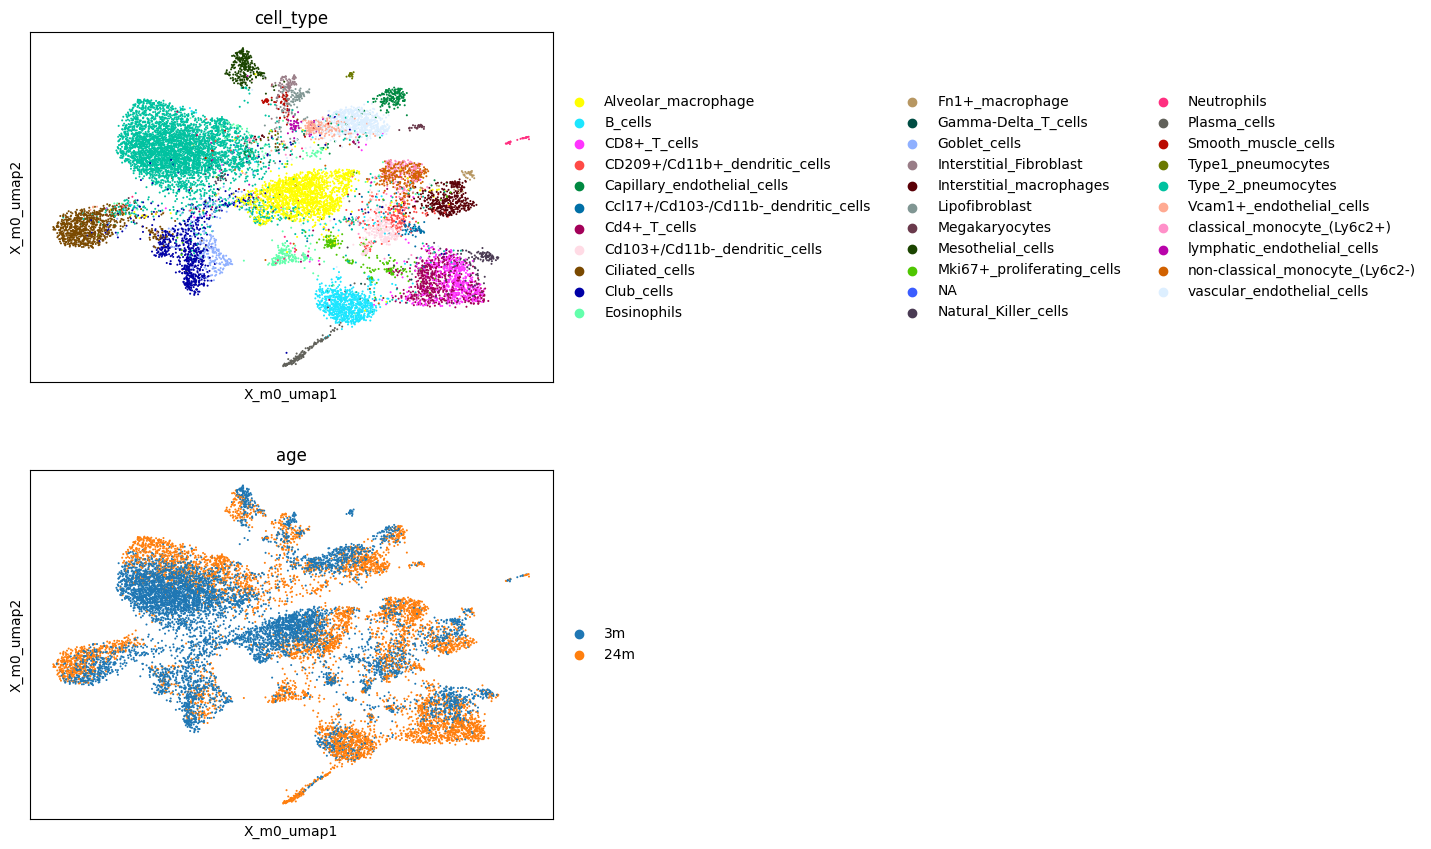

In [14]:
sc.pl.embedding(adata, basis='X_m0_umap', color=['cell_type', 'age'], ncols=1)

We now try to assess the main factors of the decomposition.

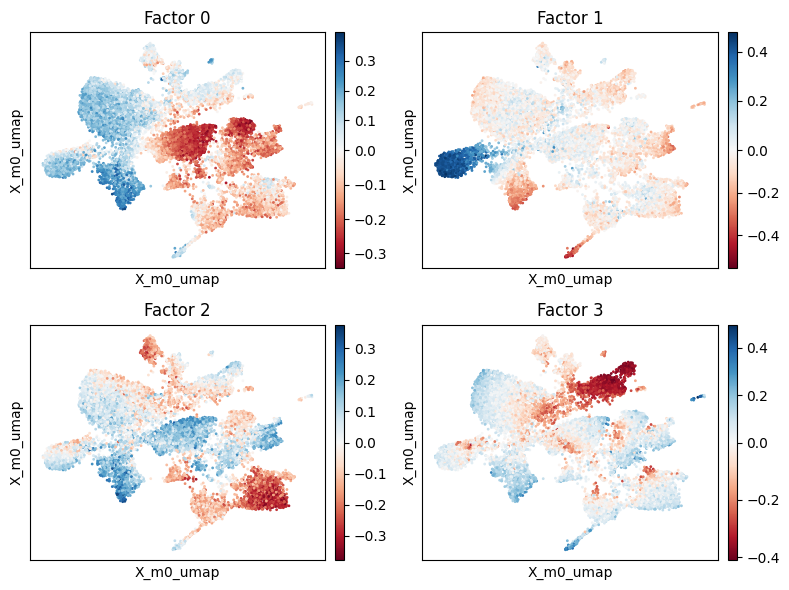

In [20]:
scp.pl.factor_embedding(adata, model_key='m0', factor=[0, 1, 2, 3], basis='X_m0_umap', ncols=2)
plt.tight_layout()

### Factor 1

Here we can see, that factor 1 for example, exhibits high weights in Ciliated Cells. Let's also have a look factor 1s corresponding loading weights.

In [31]:
top_weights_fac1 = scp.tl.state_loadings(adata, 'm0', 'Intercept', 1, highest=20)

In [33]:
top_weights_fac1.head()

,gene,magnitude,weight,type,state,factor,index
0,Fam183b,8.030411,8.030411,highest,0,1,554
1,1700016K19Rik,7.806339,7.806339,highest,0,1,15
2,Mlf1,7.700116,7.700116,highest,0,1,1041
3,Tmem212,7.574149,7.574149,highest,0,1,1443
4,1700024G13Rik,7.569454,7.569454,highest,0,1,17


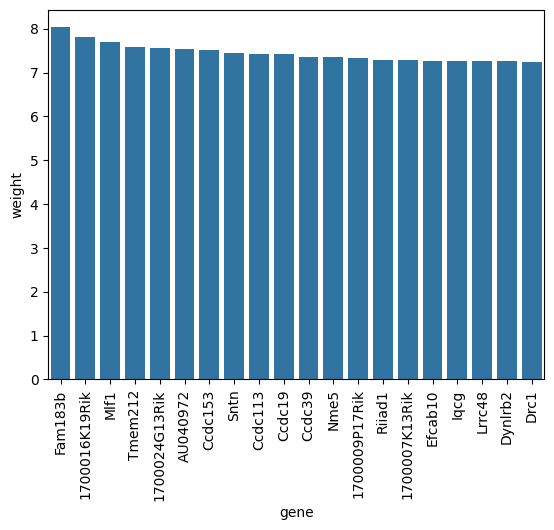

In [35]:
ax = sns.barplot(data=top_weights_fac1, x='gene', y='weight')
ax.tick_params(axis='x', rotation=90)

These genes—like _CCDC39_, _Drc1_, _Dynlrb2_, plus several coiled‑coil domain proteins (_CCDC113_, _CCDC153_, etc.)—are classic markers of motile cilia structures: they play key roles in axonemal assembly, dynein arm formation, and ciliary motility. For example, _CCDC39_ is essential for the dynein regulatory complex and inner dynein arms, and _DRC1_ also has a similar role in ciliary beat regulation.

Taken together the loading weights of factor 1 are very consistent with ciliated cells (as expected).

We next ask the question how the factor 1 changed across conditions. To this end we can compute the loading differences between factor 1 loading weigths from the 24m and 3m condition.

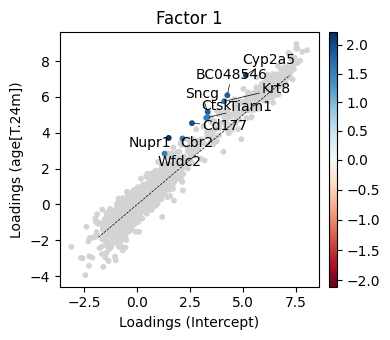

In [44]:
_ = scp.pl.loadings_state(adata, 'm0', ['Intercept', 'age[T.24m]'], 1, highest=10, width=4, height=3.5)
plt.tight_layout()

In [50]:
top_loading_diff_1 = scp.tl.state_diff(adata, 'm0',  ['Intercept', 'age[T.24m]'], 1, highest=20)

These genes, when considered collectively, point to a signature of metabolically active, detoxifying epithelial cells—possibly from liver or lung tissue. They combine:

* Detox enzymes and transporters (P450s, Sult1d1, Slc16a11)
* Epithelial structural/barrier proteins (Krt8, Cldn3, WFDC2)
* Stress response and regulatory factors (Nupr1, Tiam1, Wif1, Dkkl1)


Together these results indicate that scPCAs inferred loading weight differences indicate that ciliated cells shift toward a more metabollically active / stress respond state in old mice. 